<a href="https://colab.research.google.com/github/smslca/Huggigfaces/blob/main/Cluster_topicModelling_HLLMBOOK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers umap_learn datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
from datasets import load_dataset

In [4]:
dataset = load_dataset("maartengr/arxiv_nlp")['train']
abstracts = dataset['Abstracts']
titles = dataset['Titles']


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/617 [00:00<?, ?B/s]

data.csv:   0%|          | 0.00/53.2M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [5]:
from sentence_transformers import SentenceTransformer
embeddings_model = SentenceTransformer('thenlper/gte-small')
embeddings = embeddings_model.encode(abstracts,show_progress_bar=True)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.1k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1405 [00:00<?, ?it/s]

In [6]:
embeddings.shape

(44949, 384)

In [7]:
from umap import UMAP
umap_model = UMAP(n_components=5,min_dist=0.0,metric='cosine',random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [8]:
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 71.7 MB/s eta 0:00:00


In [9]:
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=50,metric='euclidean',cluster_selection_method='eom').fit(reduced_embeddings)
clusters = hdbscan_model.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [10]:
len(set(clusters))

153

In [11]:
import numpy as np
for index in np.where(clusters==0)[0][:3]:
  print(abstracts[index][:300])
  print('... \n')


  This works aims to design a statistical machine translation from English text
to American Sign Language (ASL). The system is based on Moses tool with some
modifications and the results are synthesized through a 3D avatar for
interpretation. First, we translate the input text to gloss, a written fo
... 

  Researches on signed languages still strongly dissociate lin- guistic issues
related on phonological and phonetic aspects, and gesture studies for
recognition and synthesis purposes. This paper focuses on the imbrication of
motion and meaning for the analysis, synthesis and evaluation of sign lang
... 

  Modern computational linguistic software cannot produce important aspects of
sign language translation. Using some researches we deduce that the majority of
automatic sign language translation systems ignore many aspects when they
generate animation; therefore the interpretation lost the truth inf
... 



In [12]:
reduced_embeddings.shape

(44949, 5)

In [13]:
import pandas as pd
u_model = UMAP(n_components=2,min_dist=0,random_state=42,metric='cosine')
reduced_embeddings = u_model.fit_transform(embeddings)
reduced_embeddings.shape

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(44949, 2)

In [14]:
df = pd.DataFrame(reduced_embeddings,columns=['x','y'])
df['title'] = titles
df['cluster'] = [str(c) for c in clusters]

In [15]:
to_plot = df.loc[df.cluster != '-1', :]
outliers = df.loc[df.cluster== '-1',:]

(-7.778345727920533,
 10.878833436965943,
 -1.711702972650528,
 16.388065367937088)

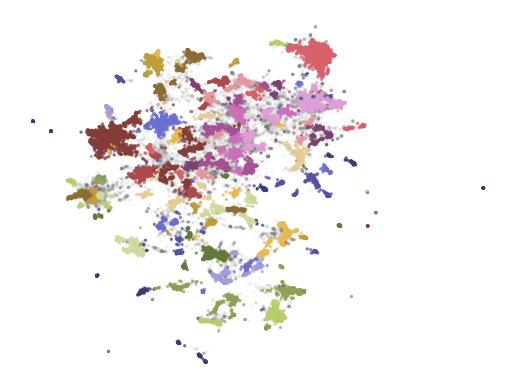

In [17]:
import matplotlib.pyplot as plt
plt.scatter(outliers.x,outliers.y,alpha=0.05,s=2,c="grey")
plt.scatter(to_plot.x,to_plot.y,alpha=0.6,s=2,c=to_plot.cluster.astype(int),cmap='tab20b')
plt.axis('off')

In [18]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 11.4 MB/s eta 0:00:00


In [19]:
from bertopic import BERTopic
topic_model = BERTopic(embedding_model=embeddings_model,
                       umap_model=umap_model,
                       hdbscan_model = hdbscan_model,
                       verbose=True).fit(abstracts,embeddings)

2024-12-22 09:23:36,234 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-22 09:24:36,706 - BERTopic - Dimensionality - Completed ✓
2024-12-22 09:24:36,709 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-22 09:24:38,740 - BERTopic - Cluster - Completed ✓
2024-12-22 09:24:38,758 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-22 09:24:43,413 - BERTopic - Representation - Completed ✓


In [20]:
topic_model.get_topic_info()

Topic  Count                                           Name  \
0       -1  14462                               -1_the_of_and_to   
1        0   2241                 0_question_questions_qa_answer   
2        1   2098                   1_speech_asr_recognition_end   
3        2    903               2_image_visual_multimodal_images   
4        3    887  3_summarization_summaries_summary_abstractive   
..     ...    ...                                            ...   
148    147     54           147_counseling_mental_therapy_health   
149    148     53                     148_chatgpt_its_openai_has   
150    149     52                149_mixed_code_sentiment_mixing   
151    150     51   150_diffusion_generation_autoregressive_text   
152    151     51         151_coherence_discourse_paragraph_text   

                                        Representation  \
0    [the, of, and, to, in, we, for, that, language...   
1    [question, questions, qa, answer, answering, a...   
2    [speech, asr, recognition, end, acoustic, audi...   
3    [image, visual, multimodal, images, vision, mo...   
4    [summarization, summaries, summary, abstractiv...   
..                                                 ...   
148  [counseling, mental, therapy, health, psychoth...   
149  [chatgpt, its, openai, has, it, tasks, capabil...   
150  [mixed, code, sentiment, mixing, english, anal...   
151  [diffusion, generation, autoregressive, text, ...   
152  [coherence, discourse, paragraph, text, cohesi...   

                                   Representative_Docs  
0    [  Cross-lingual text classification aims at t...  
1    [  Question generation (QG) attempts to solve ...  
2    [  End-to-end models have achieved impressive ...  
3    [  In this paper we propose a model to learn m...  
4    [  We present a novel divide-and-conquer metho...  
..                                                 ...  
148  [  Mental health care poses an increasingly se...  
149  [  Over the last few years, large language mod...  
150  [  In today's interconnected and multilingual ...  
151  [  Diffusion models have achieved great succes...  
152  [  While there has been significant progress t...  

[153 rows x 5 columns]

In [21]:
topic_model.get_topic(0)

[('question', 0.021262463291547223),
 ('questions', 0.015866039067984204),
 ('qa', 0.015830640927795868),
 ('answer', 0.015787698152510205),
 ('answering', 0.014859992848422435),
 ('answers', 0.00992918704536005),
 ('retrieval', 0.009497931820914705),
 ('comprehension', 0.007719047154229789),
 ('reading', 0.007175282051339653),
 ('knowledge', 0.0063049421989358)]

In [22]:
topic_model.find_topics('Sign language')

([114, 20, 2, 133, -1],
 [0.92574537, 0.8501693, 0.85003334, 0.84800845, 0.8454417])

In [23]:
topic_model.get_topic(108)

[('switching', 0.048538016927434445),
 ('code', 0.047731380453298056),
 ('switched', 0.030317013780838297),
 ('cs', 0.029941151118767523),
 ('mixed', 0.025357953962517752),
 ('hindi', 0.01807144058433493),
 ('english', 0.015760472612253884),
 ('multilingual', 0.013520896799842018),
 ('monolingual', 0.012552999778448854),
 ('mixing', 0.0111858792503415)]

In [24]:
fig = topic_model.visualize_documents(titles,reduced_embeddings = reduced_embeddings,width=1200,hide_annotations=True)
fig.update_layout(font=dict(size=16))

In [25]:
topic_model.visualize_barchart()

In [26]:
topic_model.visualize_heatmap()

In [27]:
topic_model.visualize_hierarchy()